# Naïve Bayes algorithm for classification

This notebooks includes 6 different models

1. Gaussian Naive Bayes for Binary Classification (class2)
2. Gaussian Naive Bayes for Binary Classification (class2) with normalized features
3. Gaussian Naive Bayes for Multiclass Classification (class4)
4. Gaussian Naive Bayes for Multiclass Classification (class4) with normalized
5. Bernoulli Naive Bayes for Binary Classification (class2)
6. Bernoulli Naive Bayes for Multiclass Classification (class4)

In [558]:
import pickle
import json
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd
from sklearn.naive_bayes import GaussianNB, ComplementNB, MultinomialNB, BernoulliNB, CategoricalNB
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn import preprocessing 
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.preprocessing import MinMaxScaler

#os.chdir('/Users/bwilliams/GoogleDrive/UniversityOfHelsinki/Fall2020/IML/TeamProject/TermProjectIML/bin')
os.chdir('C:/Users/saukk/Desktop/ML_Project/bin')
from SplitData import *

### Define help function

In [559]:
def print_nbr_classes(name, df):
    set_size=len(df)
    print(name, "set")
    print("nonevent:", len(df[df["class4"]=="nonevent"]), "pcs", round(len(df[df["class4"]=="nonevent"])/set_size, 3), "%")
    print("II:", len(df[df["class4"]=="II"]), "pcs", round(len(df[df["class4"]=="II"])/set_size, 3), "%")
    print("Ib:", len(df[df["class4"]=="Ib"]), "pcs", round(len(df[df["class4"]=="Ib"])/set_size, 3), "%")
    print("Ia:", len(df[df["class4"]=="Ia"]), "pcs", round(len(df[df["class4"]=="Ia"])/set_size, 3), "%")
    print("Total:", set_size, "pcs")
    print("")

def data_cleaner(df):
    data = df.copy()
    
    #remove the id, partlybad columns
    data.drop(["id","partlybad", "date"],1,inplace=True)
    
    #set new index using the date column
    #data.set_index(["date"],inplace=True)
    
    #add binary 'class2' col for event/non-event
    data["class2"] = np.where(data["class4"] == "nonevent", "nonevent","event")
    
    #arrange to put class2 col at the front
    cols = ['class2'] + [col for col in data if col != 'class2']
    
    # Return cleaned and re-arranged dataframe
    return data[cols]


def normalize_0to1(df):
    # create a scaler object
    scaler = MinMaxScaler()
    # fit and transform the data
    df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    # Return result
    return df_norm

def find_n_best_feature(X, y, n):
    # Normalize X values to be between 0 and 1
    #x = X.values
    #min_max_scaler = preprocessing.MinMaxScaler()
    #x_scaled = min_max_scaler.fit_transform(x)
    #X = pd.DataFrame(x_scaled)

    # Use SelectKBest class to extract top n best features
    bestfeatures = SelectKBest(score_func=chi2, k=n)
    fit = bestfeatures.fit(X_train_norm, y_train)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(X_train_norm.columns)
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['col_name','Score']
    featureScores= featureScores.nlargest(n,'Score')
    cols = list(featureScores["col_name"])
    return cols

### Import data and print length and categorical distribution

In [560]:
X_train = X_train
X_train_norm = X_train_norm
y_train = y_train
y_train_bin = convert_binary(y_train)
print("Train set")
print("Len:",len(y_train))
print(y_train.value_counts(normalize=True),"\n")

X_test = X_test
X_test_norm = X_test_norm
y_test = y_test
y_test_bin = convert_binary(y_test)
print("Test set")
print("Len:",len(y_test))
print(y_test.value_counts(normalize=True),"\n")

X_val = X_val
X_val_norm = X_val_norm
y_val = y_val
y_val_bin = convert_binary(y_val)
print("Validation set")
print("Len:",len(y_val))
print(y_val.value_counts(normalize=True),"\n")

X_trainval = X_trainval
X_trainval_norm = X_trainval_norm
y_trainval = y_trainval
y_trainval_bin = convert_binary(y_trainval)
print("Trainvalidation set")
print("Len:",len(y_trainval))
print(y_trainval.value_counts(normalize=True),"\n")

os.chdir('C:/Users/saukk/Desktop/ML_Project')
npf_train = pd.read_csv("data/npf_train.csv")
npf_train = data_cleaner(npf_train)
print_nbr_classes("npf_train", npf_train)

Train set
Len: 154
nonevent    0.493506
II          0.220779
Ib          0.214286
Ia          0.071429
Name: class4, dtype: float64 

Test set
Len: 52
nonevent    0.500000
II          0.211538
Ib          0.211538
Ia          0.076923
Name: class4, dtype: float64 

Validation set
Len: 52
nonevent    0.500000
II          0.211538
Ib          0.211538
Ia          0.076923
Name: class4, dtype: float64 

Trainvalidation set
Len: 206
nonevent    0.495146
II          0.218447
Ib          0.213592
Ia          0.072816
Name: class4, dtype: float64 

npf_train set
nonevent: 215 pcs 0.5 %
II: 106 pcs 0.247 %
Ib: 83 pcs 0.193 %
Ia: 26 pcs 0.06 %
Total: 430 pcs



### Make correlation matrix

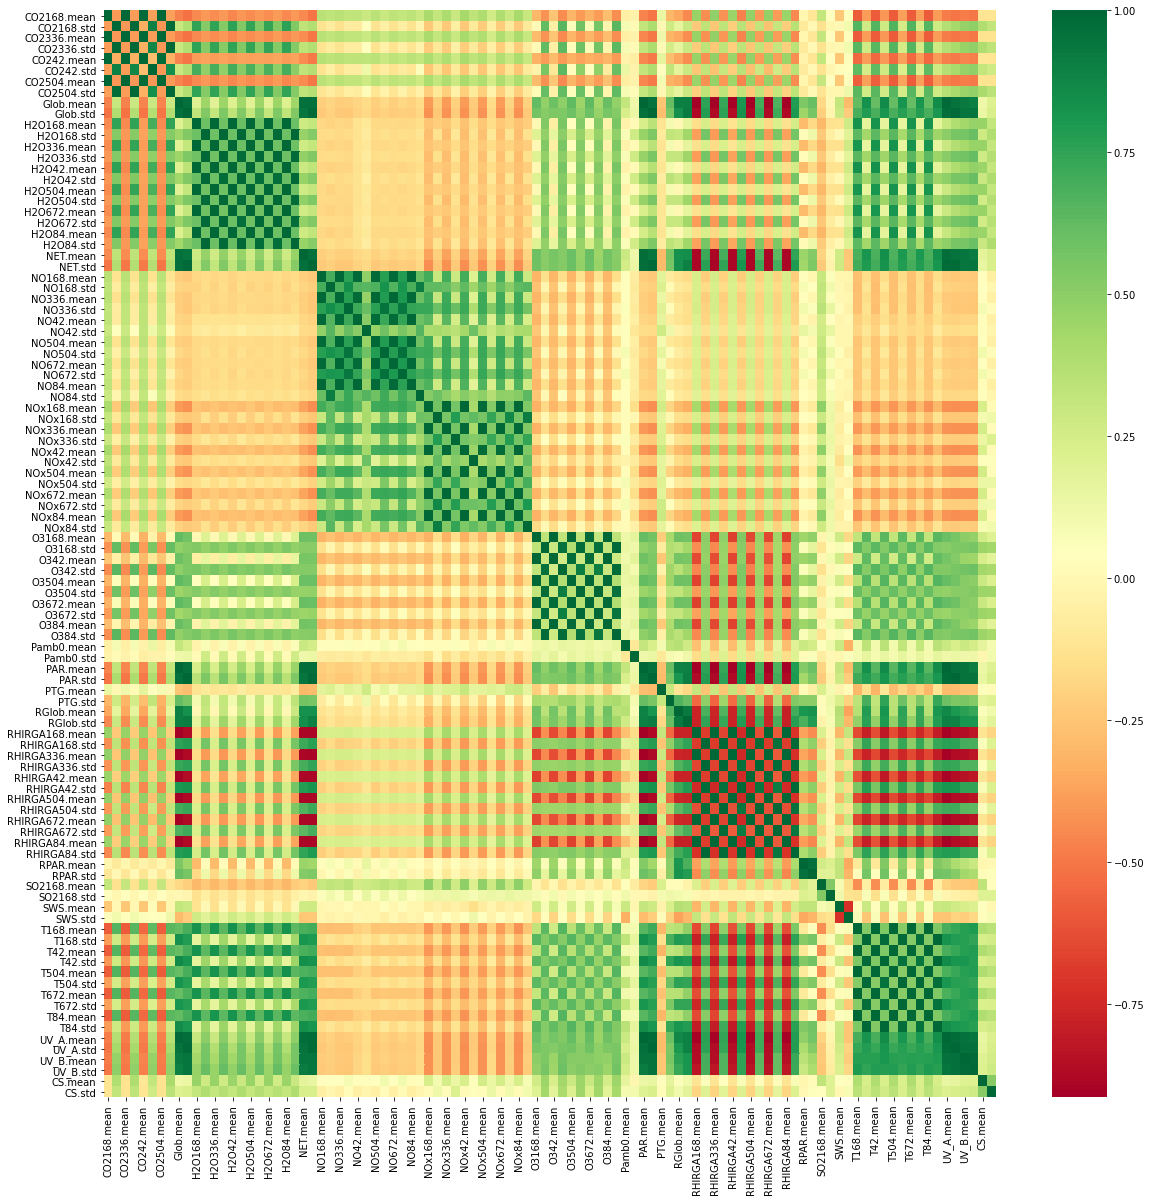

In [561]:
corrmat = npf_train.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
g=sns.heatmap(npf_train[top_corr_features].corr(),annot=False,cmap="RdYlGn")
plt.savefig('npf_train_correlationmatrix.pdf')  

## Test Naive Bayes accuracy

### Gaussian Naive Bayes Binary classification (class2)

In [562]:
model = GaussianNB()
model.fit(X_train, y_train_bin)

print("Gaussian Naive Bayes binary classification")
print("Train set accurancy:", round(accuracy_score(y_train_bin, model.predict(X_train)),2))
print("Test set accurancy:", round(accuracy_score(y_test_bin, model.predict(X_test)),2))
print("Validation set accurancy:", round(accuracy_score(y_val_bin, model.predict(X_val)), 2))

Gaussian Naive Bayes binary classification
Train set accurancy: 0.78
Test set accurancy: 0.81
Validation set accurancy: 0.79


### Gaussian Naive Bayes Binary classification (class2) normalized features

In [563]:
model = GaussianNB()
model.fit(X_train_norm, y_train_bin)

print("Gaussian Naive Bayes binary classification normalized features")
print("Train set accurancy:", round(accuracy_score(y_train_bin, model.predict(X_train_norm)),2))
print("Test set accurancy:", round(accuracy_score(y_test_bin, model.predict(X_test_norm)),2))
print("Validation set accurancy:", round(accuracy_score(y_val_bin, model.predict(X_val_norm)), 2))

Gaussian Naive Bayes binary classification normalized features
Train set accurancy: 0.78
Test set accurancy: 0.69
Validation set accurancy: 0.81


### Bernoulli Naive Bayes Binary classification (class2)

In [564]:
model = BernoulliNB()
model.fit(X_train, y_train_bin)

print("Bernoulli Naive Bayes binary classification")
print("Train set accurancy:", round(accuracy_score(y_train_bin, model.predict(X_train)),2))
print("Test set accurancy:", round(accuracy_score(y_test_bin, model.predict(X_test)),2))
print("Validation set accurancy:", round(accuracy_score(y_val_bin, model.predict(X_val)), 2))

Bernoulli Naive Bayes binary classification
Train set accurancy: 0.64
Test set accurancy: 0.52
Validation set accurancy: 0.63


### Bernoulli Naive Bayes Binary classification (class2) normalized features

In [565]:
model = BernoulliNB()
model.fit(X_train_norm, y_train_bin)

print("Bernoulli Naive Bayes binary classification normalized features")
print("Train set accurancy:", round(accuracy_score(y_train_bin, model.predict(X_train_norm)),2))
print("Test set accurancy:", round(accuracy_score(y_test_bin, model.predict(X_test_norm)),2))
print("Validation set accurancy:", round(accuracy_score(y_val_bin, model.predict(X_val_norm)), 2))

Bernoulli Naive Bayes binary classification normalized features
Train set accurancy: 0.66
Test set accurancy: 0.56
Validation set accurancy: 0.65


### Gaussian Naive Bayes Multiclass classification (class4)

In [566]:
model = GaussianNB()
model.fit(X_train, y_train)

print("Gaussian Naive Bayes Multiclass classification")
print("Train set accurancy:", round(accuracy_score(y_train, model.predict(X_train)),2))
print("Test set accurancy:", round(accuracy_score(y_test, model.predict(X_test)),2))
print("Validation set accurancy:", round(accuracy_score(y_val, model.predict(X_val)), 2))

Gaussian Naive Bayes Multiclass classification
Train set accurancy: 0.54
Test set accurancy: 0.46
Validation set accurancy: 0.37


### Gaussian Naive Bayes Multiclass classification (class4) normalized features

In [567]:
model = GaussianNB()
model.fit(X_train_norm, y_train)

print("Gaussian Naive Bayes Multiclass classification normalized features")
print("Train set accurancy:", round(accuracy_score(y_train, model.predict(X_train_norm)),2))
print("Test set accurancy:", round(accuracy_score(y_test, model.predict(X_test_norm)),2))
print("Validation set accurancy:", round(accuracy_score(y_val, model.predict(X_val_norm)), 2))

Gaussian Naive Bayes Multiclass classification normalized features
Train set accurancy: 0.54
Test set accurancy: 0.52
Validation set accurancy: 0.42


### Bernoulli Naive Bayes Multiclass classification (class4)

In [568]:
model = BernoulliNB()
model.fit(X_train, y_train)

print("Bernoulli Naive Bayes Multiclass classification")
print("Train set accurancy:", round(accuracy_score(y_train, model.predict(X_train)),2))
print("Test set accurancy:", round(accuracy_score(y_test, model.predict(X_test)),2))
print("Validation set accurancy:", round(accuracy_score(y_val, model.predict(X_val)), 2))

Bernoulli Naive Bayes Multiclass classification
Train set accurancy: 0.49
Test set accurancy: 0.46
Validation set accurancy: 0.46


### Bernoulli Naive Bayes Multiclass classification (class4) normalized features

In [569]:
model = BernoulliNB()
model.fit(X_train_norm, y_train)

print("Bernoulli Naive Bayes Multiclass classification normalized features")
print("Train set accurancy:", round(accuracy_score(y_train, model.predict(X_train_norm)),2))
print("Test set accurancy:", round(accuracy_score(y_test, model.predict(X_test_norm)),2))
print("Validation set accurancy:", round(accuracy_score(y_val, model.predict(X_val_norm)), 2))

Bernoulli Naive Bayes Multiclass classification normalized features
Train set accurancy: 0.51
Test set accurancy: 0.42
Validation set accurancy: 0.35


### Gaussian Naive Bayes Binary accuracy for n number of kBest features

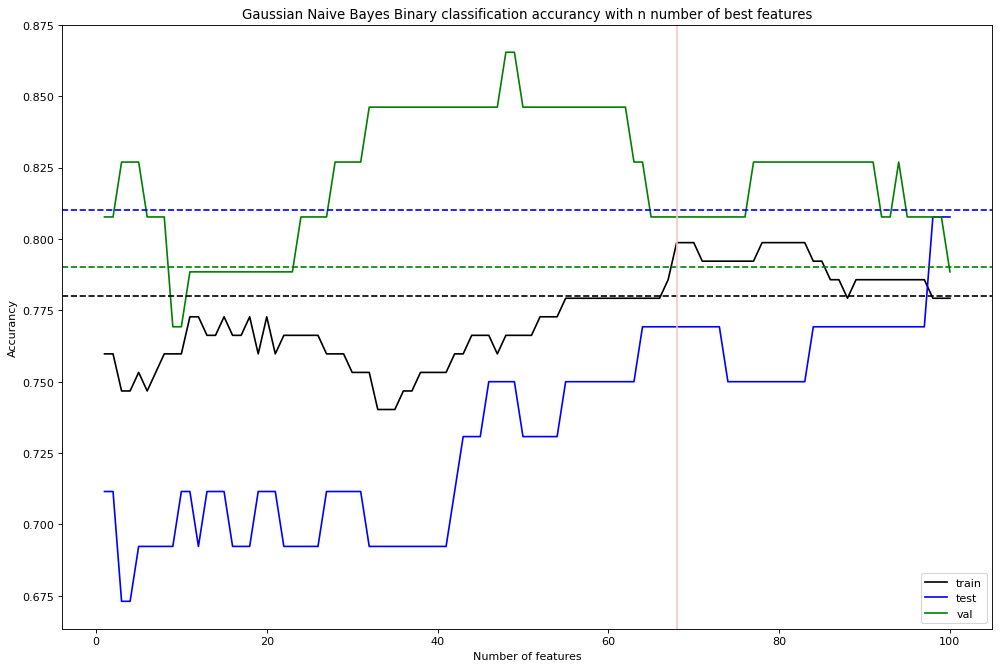

In [570]:
# Define X and y for full dataset
X_npf = npf_train.iloc[:,2:]
y_npf_bin = npf_train["class2"]
X_npf = normalize_0to1(X_npf)

len_cols = len(X_train_norm.columns)+1

acc_train = []
acc_test = []
acc_val = []

for i in range(1, len_cols):
    
    # Train filter with full dataset. Find i number of best col names.
    bestFeatureCols = find_n_best_feature(X_train, y_train, i)
    
    # Filter train, val and test set with bestFeaturesFilter
    X_train_i = X_train[bestFeatureCols]
    X_val_i = X_val[bestFeatureCols]
    X_test_i = X_test[bestFeatureCols]
        
    # Train Gaussian Naive Bayes model
    model = GaussianNB()
    model.fit(X_train_i, y_train_bin)
    
    # Save accurancy to list
    acc_train.append(accuracy_score(y_train_bin, model.predict(X_train_i)))
    acc_test.append(accuracy_score(y_test_bin, model.predict(X_test_i)))
    acc_val.append(accuracy_score(y_val_bin, model.predict(X_val_i)))

acc_train_max = acc_train.index(max(acc_train))+1    
    
# Plot the results
figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
x = range(1, len_cols)
plt.plot(x, acc_train, color="black")
plt.plot(x, acc_test, color="blue")
plt.plot(x, acc_val, color="green")
#Train set accurancy: 0.78
#Test set accurancy: 0.81
#Validation set accurancy: 0.79
plt.axhline(y=0.78, color='black', linestyle='--')
plt.axhline(y=0.81, color='blue', linestyle='--')
plt.axhline(y=0.79, color='green', linestyle='--')
# Vertical line to points with max values
plt.axvline(acc_train_max, color='pink', linestyle='-')
plt.title('Gaussian Naive Bayes Binary classification accurancy with n number of best features')
plt.xlabel('Number of features')
plt.ylabel('Accurancy')
plt.legend(["train", "test", "val"], loc ="lower right") 
plt.show()

In [580]:
# Train filter with full dataset. Find i number of best col names.
bestFeatureCols = find_n_best_feature(X_train, y_train, acc_train_max)
    
# Filter train, val and test set with bestFeaturesFilter
X_train_i = X_train[bestFeatureCols]
X_val_i = X_val[bestFeatureCols]
X_test_i = X_test[bestFeatureCols]

model = GaussianNB()
model.fit(X_train_i, y_train_bin)

print("Gaussian Naive Bayes Multiclass classification with", acc_train_max, "best features")
print("Train set accurancy:", round(accuracy_score(y_train_bin, model.predict(X_train_i)),2))
print("Test set accurancy:", round(accuracy_score(y_test_bin, model.predict(X_test_i)),2))
print("Validation set accurancy:", round(accuracy_score(y_val_bin, model.predict(X_val_i)), 2))

Gaussian Naive Bayes Multiclass classification with 73 best features
Train set accurancy: 0.79
Test set accurancy: 0.77
Validation set accurancy: 0.81


In [ ]:
# Make dataframe of accurancy values
df_acc = pd.DataFrame(list(zip(acc_train, acc_val)),columns=['acc_train', 'acc_val'])
df_acc['mean'] = df_acc.mean(axis=1)

# Drop first n values, because we want k to be greated than threshold n
n = 20
df_acc = df_acc.drop(range(0, n)) 

# Get best k value
acc_train_val_mean = df_acc["mean"].idxmax()

print("Hights mean of acc_train and acc_val is in:", acc_train_val_mean)
print("Hights cc_train is in:", acc_train_max)

## Gaussian Naive Bayes Multiclass accuracy for n number of kBest features

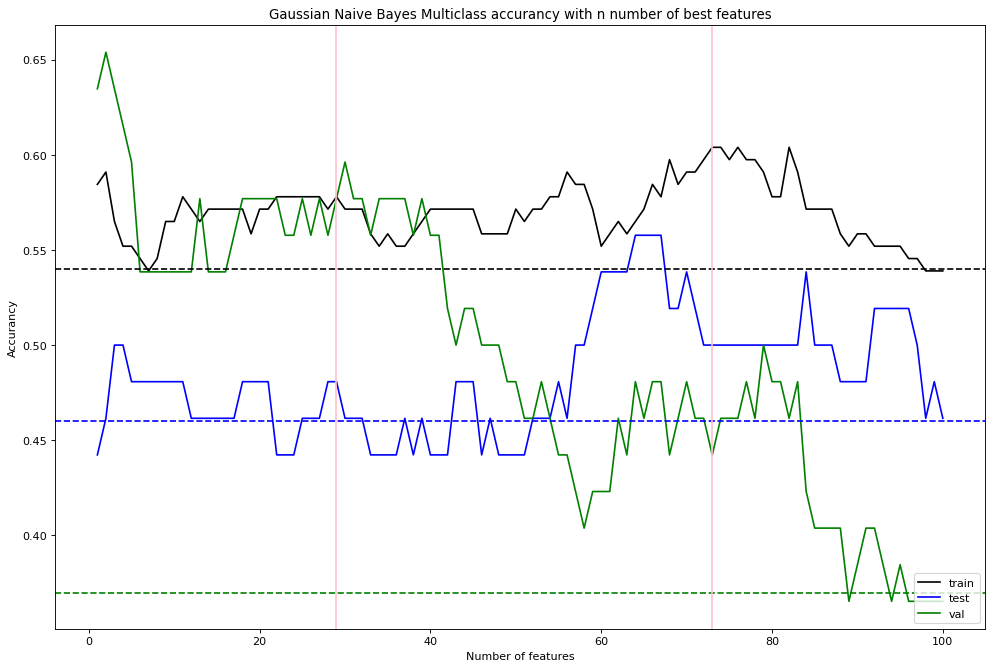

In [571]:
# Define X and y for full dataset
X_npf = npf_train.iloc[:,2:]
y_npf = npf_train["class4"]
X_npf = normalize_0to1(X_npf)

len_cols = len(X_train_norm.columns)+1

acc_train = []
acc_test = []
acc_val = []

for i in range(1, (len_cols)):
    
    # Train filter with full dataset. Find i number of best col names.
    bestFeatureCols = find_n_best_feature(X_train, y_train, i)
    
    # Filter train, val and test set with bestFeaturesFilter
    X_train_i = X_train[bestFeatureCols]
    X_val_i = X_val[bestFeatureCols]
    X_test_i = X_test[bestFeatureCols]
    
    #X_val_i = bestFeaturesFilter.fit_transform(X_val_norm, y_val)
    #X_test_i = bestFeaturesFilter.fit_transform(X_test_norm, y_test)
    
    
    # Train Gaussian Naive Bayes model
    model = GaussianNB()
    model.fit(X_train_i, y_train)
    
    # Save accurancy to list
    acc_train.append(accuracy_score(y_train, model.predict(X_train_i)))
    acc_test.append(accuracy_score(y_test, model.predict(X_test_i)))
    acc_val.append(accuracy_score(y_val, model.predict(X_val_i)))

    
acc_train_max = acc_train.index(max(acc_train))+1

# Plot the results
figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
x = range(1, len_cols)
plt.plot(x, acc_train, color="black")
plt.plot(x, acc_test, color="blue")
plt.plot(x, acc_val, color="green")
plt.axhline(y=0.54, color='black', linestyle='--')
plt.axhline(y=0.46, color='blue', linestyle='--')
plt.axhline(y=0.37, color='green', linestyle='--')
# Plot vertical lines to max points
plt.axvline(acc_train_max, color='pink', linestyle='-')
plt.axvline(29, color='pink', linestyle='-')

plt.title('Gaussian Naive Bayes Multiclass accurancy with n number of best features')
plt.xlabel('Number of features')
plt.ylabel('Accurancy')
plt.legend(["train", "test", "val"], loc ="lower right") 
plt.show()

In [572]:
# Make dataframe of accurancy values
df_acc = pd.DataFrame(list(zip(acc_train, acc_val)),columns=['acc_train', 'acc_val'])
df_acc['mean'] = df_acc.mean(axis=1)

# Drop first n values, because we want k to be greated than threshold n
n = 20
df_acc = df_acc.drop(range(0, n)) 

# Get best k value
acc_train_val_mean = df_acc["mean"].idxmax()

print("Hights mean of acc_train and acc_val is in:", acc_train_val_mean)
print("Hights cc_train is in:", acc_train_max)

Hights mean of acc_train and acc_val is in: 29
Hights cc_train is in: 73


In [573]:
# Train filter with full dataset. Find i number of best col names.
bestFeatureCols = find_n_best_feature(X_train, y_train, acc_train_val_mean)
    
# Filter train, val and test set with bestFeaturesFilter
X_train_i = X_train[bestFeatureCols]
X_val_i = X_val[bestFeatureCols]
X_test_i = X_test[bestFeatureCols]

model = GaussianNB()
model.fit(X_train_i, y_train)

print("Gaussian Naive Bayes Multiclass classification with", acc_train_val_mean, "best features")
print("Train set accurancy:", round(accuracy_score(y_train, model.predict(X_train_i)),2))
print("Test set accurancy:", round(accuracy_score(y_test, model.predict(X_test_i)),2))
print("Validation set accurancy:", round(accuracy_score(y_val, model.predict(X_val_i)), 2))

Gaussian Naive Bayes Multiclass classification with 29 best features
Train set accurancy: 0.58
Test set accurancy: 0.48
Validation set accurancy: 0.58


In [574]:
# Train filter with full dataset. Find i number of best col names.
bestFeatureCols = find_n_best_feature(X_train, y_train, acc_train_max)
    
# Filter train, val and test set with bestFeaturesFilter
X_train_i = X_train[bestFeatureCols]
X_val_i = X_val[bestFeatureCols]
X_test_i = X_test[bestFeatureCols]

model = GaussianNB()
model.fit(X_train_i, y_train)

print("Gaussian Naive Bayes Multiclass classification with", acc_train_max, "best features")
print("Train set accurancy:", round(accuracy_score(y_train, model.predict(X_train_i)),2))
print("Test set accurancy:", round(accuracy_score(y_test, model.predict(X_test_i)),2))
print("Validation set accurancy:", round(accuracy_score(y_val, model.predict(X_val_i)), 2))

Gaussian Naive Bayes Multiclass classification with 73 best features
Train set accurancy: 0.6
Test set accurancy: 0.5
Validation set accurancy: 0.44


## Normalized vs not normalized - KESKEN

In [575]:
from matplotlib.pyplot import figure



acc_train = []
acc_test = []
acc_val = []
acc_train_norm = []
acc_test_norm = []
acc_val_norm = []

for i in range(3, len_cols):
    y_train = train["class4"]
    X_train = train.iloc[:,2:i]
    X_train_norm = normalize_0to1(X_train)
    
    y_val = validation["class4"]
    X_val = validation.iloc[:,2:i]
    X_val_norm = normalize_0to1(X_val)
    
    y_test = test["class4"]
    X_test = test.iloc[:,2:i]
    X_test_norm = normalize_0to1(X_test)
    
    # Unnormalize azzuranzy
    model = GaussianNB()
    model.fit(X_train, y_train)
    acc_train.append(accuracy_score(y_train, model.predict(X_train)))
    acc_test.append(accuracy_score(y_test, model.predict(X_test)))
    acc_val.append(accuracy_score(y_val, model.predict(X_val)))
    
    # Normalize azzuranzy
    model = GaussianNB()
    model.fit(X_train_norm, y_train)
    acc_train_norm.append(accuracy_score(y_train, model.predict(X_train_norm)))
    acc_test_norm.append(accuracy_score(y_test, model.predict(X_test_norm)))
    acc_val_norm.append(accuracy_score(y_val, model.predict(X_val_norm)))
 
figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
x = range(0, len(acc_train))
plt.plot(x, acc_train, color="black")
plt.plot(x, acc_train_norm, color="yellow")

plt.plot(x, acc_test, color="blue")
plt.plot(x, acc_test_norm, color="red")

plt.plot(x, acc_val, color="green")
plt.plot(x, acc_val_norm, color="gray")

plt.title('Gaussian Naive Bayes Multinomial accurancy with features from index 2 to i')
plt.xlabel('i')
plt.ylabel('Accurancy')
plt.legend(["train", "train_norm", "test", "test_norm", "val", "val_norm"], loc ="lower right") 
plt.show()

NameError: name 'train' is not defined